# Predict Future Sales

<img src="images/thumb76_76.png" />

### File descriptions
 - sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
 - test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
 - sample_submission.csv - a sample submission file in the correct format.
 - items.csv - supplemental information about the items/products.
 - item_categories.csv  - supplemental information about the items categories.
 - shops.csv- supplemental information about the shops.


### Data fields
 - ID - an Id that represents a (Shop, Item) tuple within the test set
 - shop_id - unique identifier of a shop
 - item_id - unique identifier of a product
 - item_category_id - unique identifier of item category
 - item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
 - item_price - current price of an item
 - date - date in format dd/mm/yyyy
 - date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
 - item_name - name of item
 - shop_name - name of shop
 - item_category_name - name of item category

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train = pd.read_csv('./data/sales_train.csv')
item_cat = pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# Lets format the date a little better
train.date = pd.to_datetime(train.date, format='%d.%m.%Y')

In [5]:
print(items.head())
print(shops.head())
print(item_cat.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4             

In [6]:

from googletrans import Translator

translator = Translator()

def safe_translate(phrase):
    try:
        return(translator.translate(phrase).text)
    except:
        return('-'.join([phrase,'unable to translate']))

item_cat['item_category_name_eng'] = item_cat.item_category_name.apply(lambda t: safe_translate(t))
items['item_name_eng'] = items.item_name.apply(lambda t: safe_translate(t))
shops['shop_name_eng'] = shops.shop_name.apply(lambda t: safe_translate(t))


In [14]:
#items.to_hdf('./data/item_categories.csv')
#shops.to_hdf('./data/item_categories.csv')
#shops.to_hdf('./data/item_categories.csv')

items = pd.read_hdf('/home/nick/GIT/predict_future_sales/data/items_w_eng.h5')
shops = pd.read_hdf('/home/nick/GIT/predict_future_sales/data/shops_w_eng.h5')
item_cat = pd.read_hdf('/home/nick/GIT/predict_future_sales/data/item_categories_w_eng.h5')

item_cat.head()

,item_category_name,item_category_id,item_category_name_eng
0,PC - Гарнитуры/Наушники,0,PC - Headsets / Headphones
1,Аксессуары - PS2,1,Accessories - PS2
2,Аксессуары - PS3,2,Accessories - PS3
3,Аксессуары - PS4,3,Accessories - PS4
4,Аксессуары - PSP,4,Accessories - PSP


In [77]:
joined = pd.merge(train,items, on=['item_id'], how='left')
joined = pd.merge(joined,item_cat, on=['item_category_id'], how='left')
joined = pd.merge(joined,shops, on=['shop_id'], how='left')

joined['revenue_day'] = joined.item_price * joined.item_cnt_day
joined['return'] = joined.item_cnt_day < 0

joined.head(10)
joined.to_hdf('data/joined.h5','item_id')

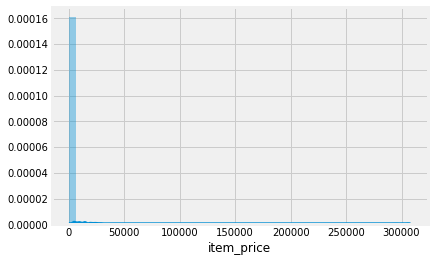

In [16]:
sns.distplot(joined.item_price)

It looks like item price is highly skewed right, lets transform and see what we get

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


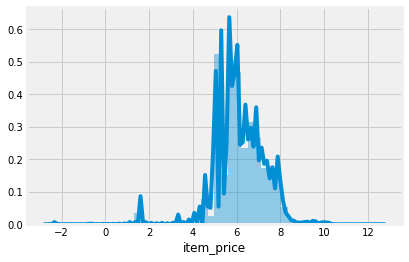

In [17]:
sns.distplot(np.log(joined.item_price).fillna(0))

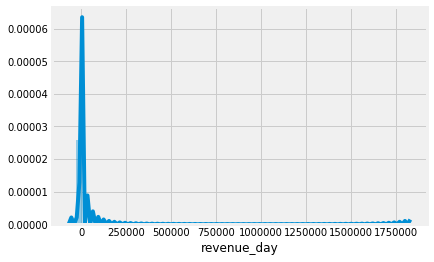

In [18]:
sns.distplot(joined.revenue_day)

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


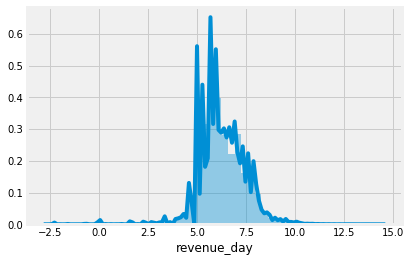

In [19]:
sns.distplot(np.log(joined.revenue_day).fillna(0))

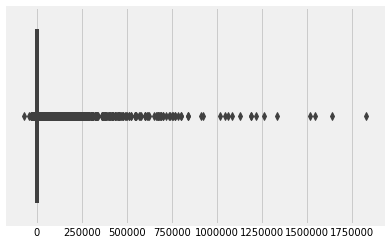

In [20]:
sns.boxplot(joined[['revenue_day','item_price']])

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


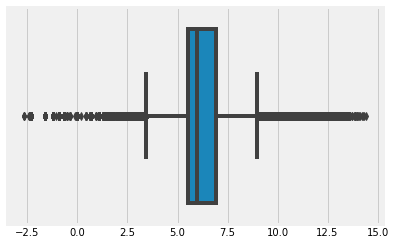

In [21]:
sns.boxplot(np.log(joined[['revenue_day','item_price']]).dropna())

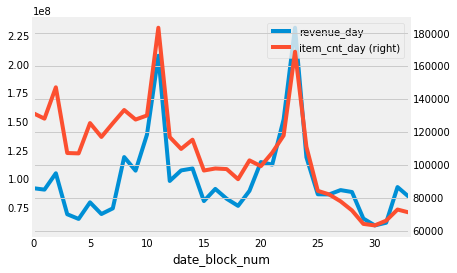

In [22]:
joined.groupby(['date_block_num'])['revenue_day'].sum().plot(legend=True)
joined.groupby(['date_block_num'])['item_cnt_day'].sum().plot(secondary_y=True,legend=True)

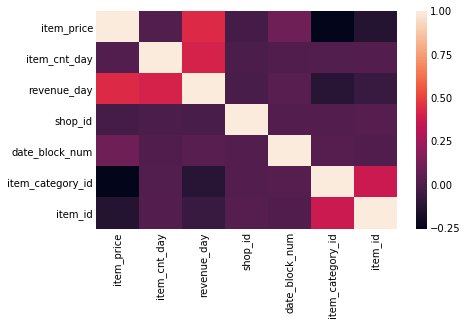

In [23]:
sns.heatmap(joined[['item_price','item_cnt_day','revenue_day','shop_id',
                    'date_block_num','item_category_id','item_id']].corr())

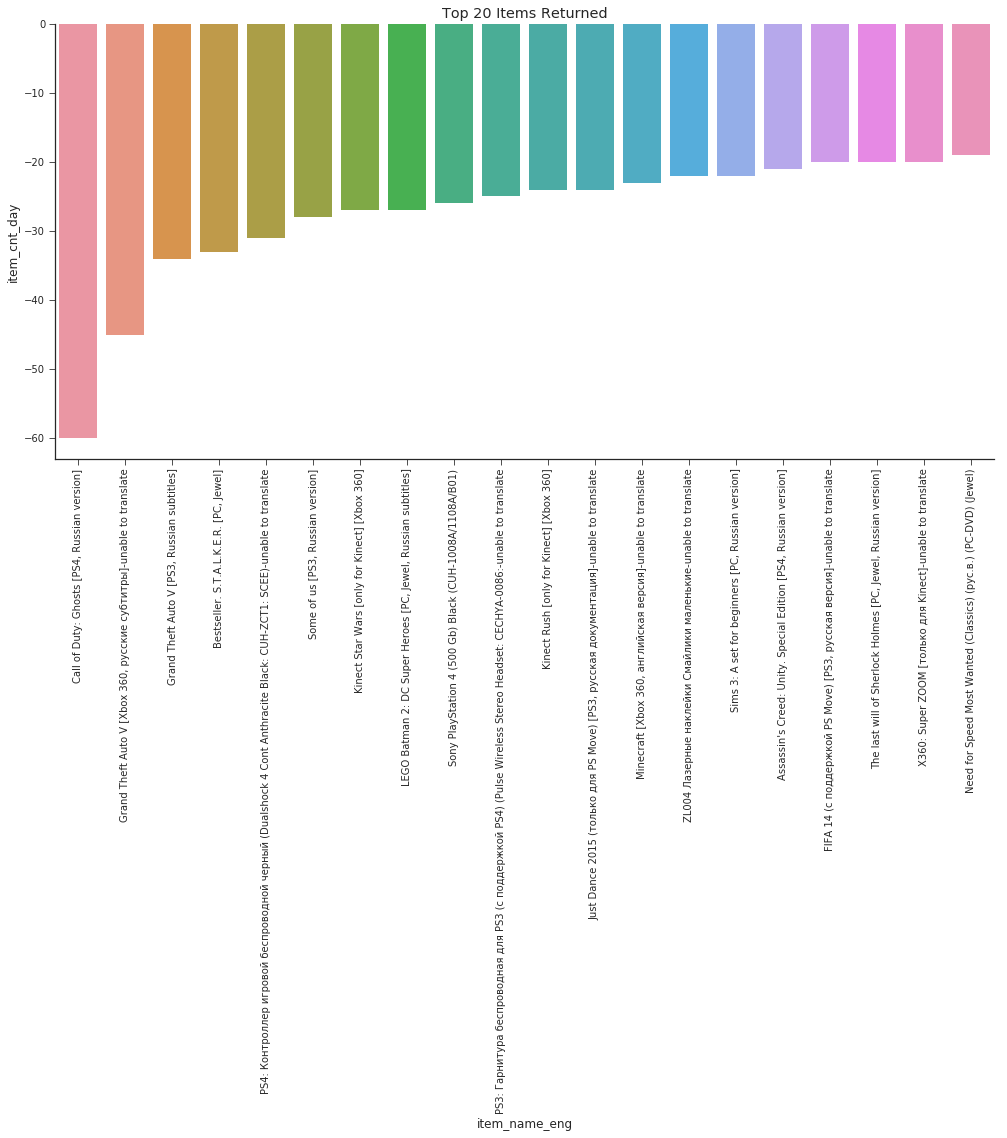

In [63]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)


sns.barplot(x='item_name_eng',y='item_cnt_day',
            data=joined[joined.item_cnt_day<0].groupby(['item_name_eng'])['item_name_eng','item_cnt_day'].sum().reset_index().sort_values('item_cnt_day').head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Items Returned')
sns.despine()

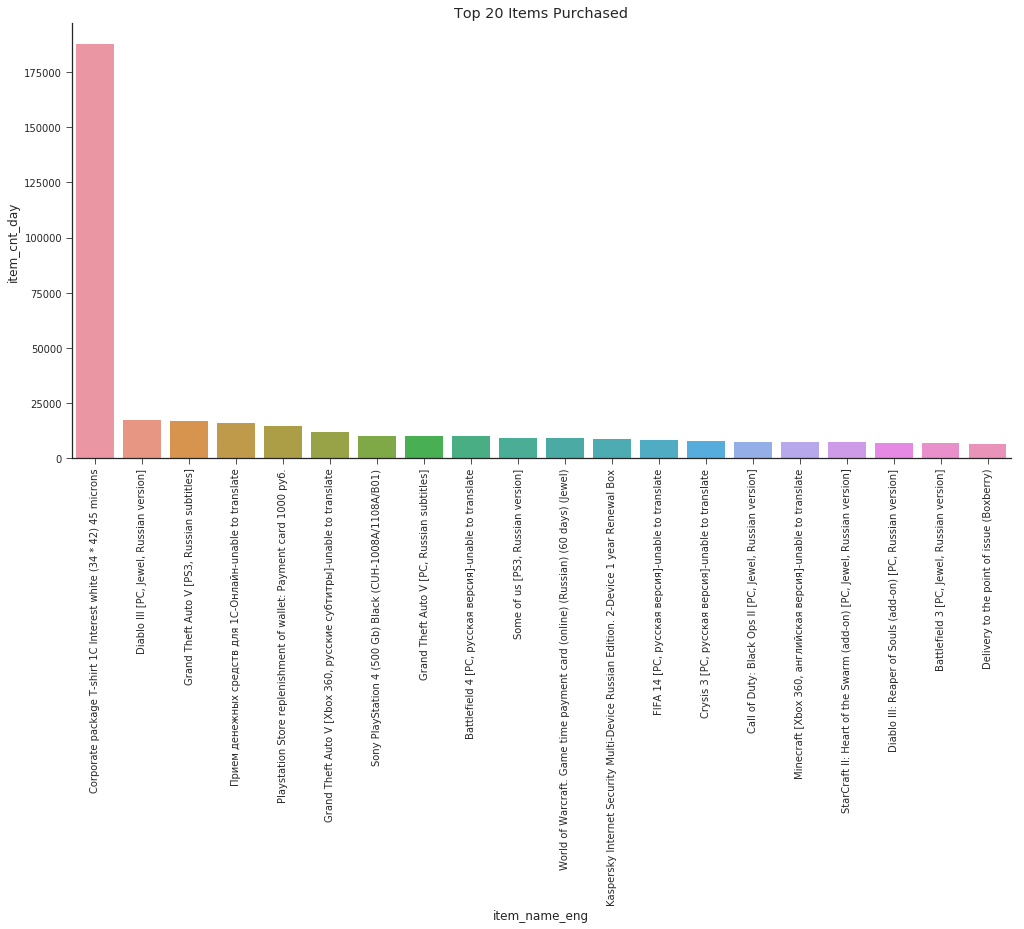

In [65]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)


sns.barplot(x='item_name_eng',y='item_cnt_day',
            data=joined[joined.item_cnt_day>0].groupby(['item_name_eng'])['item_name_eng','item_cnt_day'].sum().reset_index().sort_values('item_cnt_day',ascending=False).head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Items Purchased')
sns.despine()

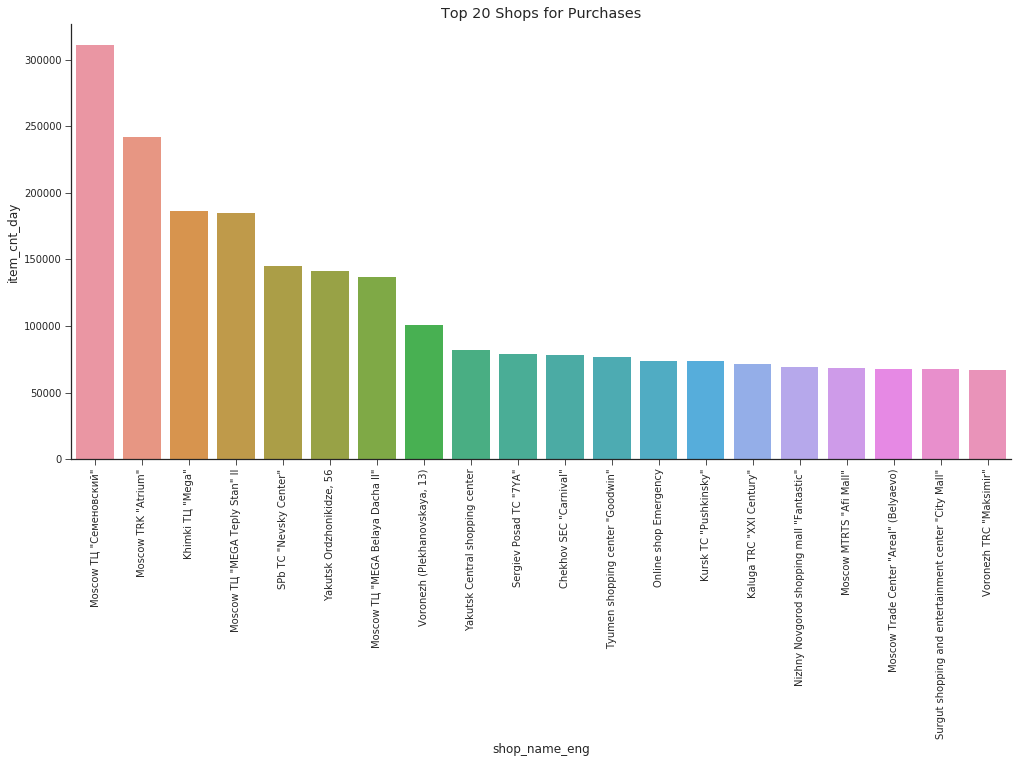

In [67]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)


sns.barplot(x='shop_name_eng',y='item_cnt_day',
            data=joined[joined.item_cnt_day>0].groupby(['shop_name_eng'])['shop_name_eng','item_cnt_day'].sum().reset_index().sort_values('item_cnt_day',ascending=False).head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Shops for Purchases')
sns.despine()

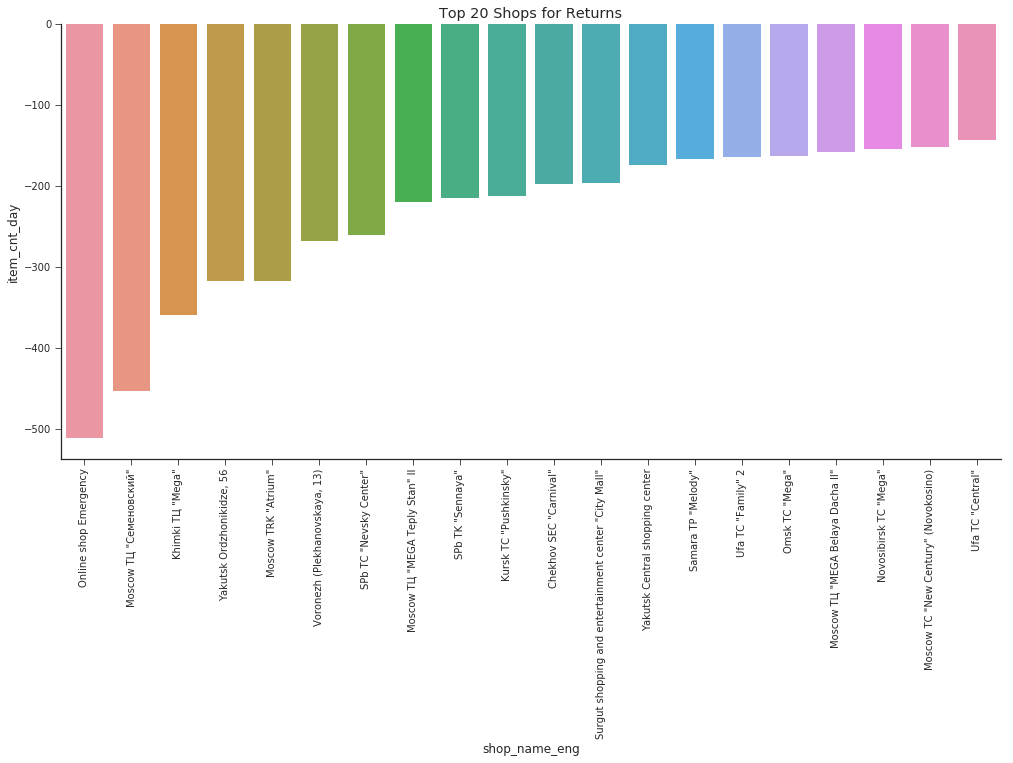

In [69]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)


sns.barplot(x='shop_name_eng',y='item_cnt_day',
            data=joined[joined.item_cnt_day<0].groupby(['shop_name_eng'])['shop_name_eng','item_cnt_day'].sum().reset_index().sort_values('item_cnt_day').head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Shops for Returns')
sns.despine()

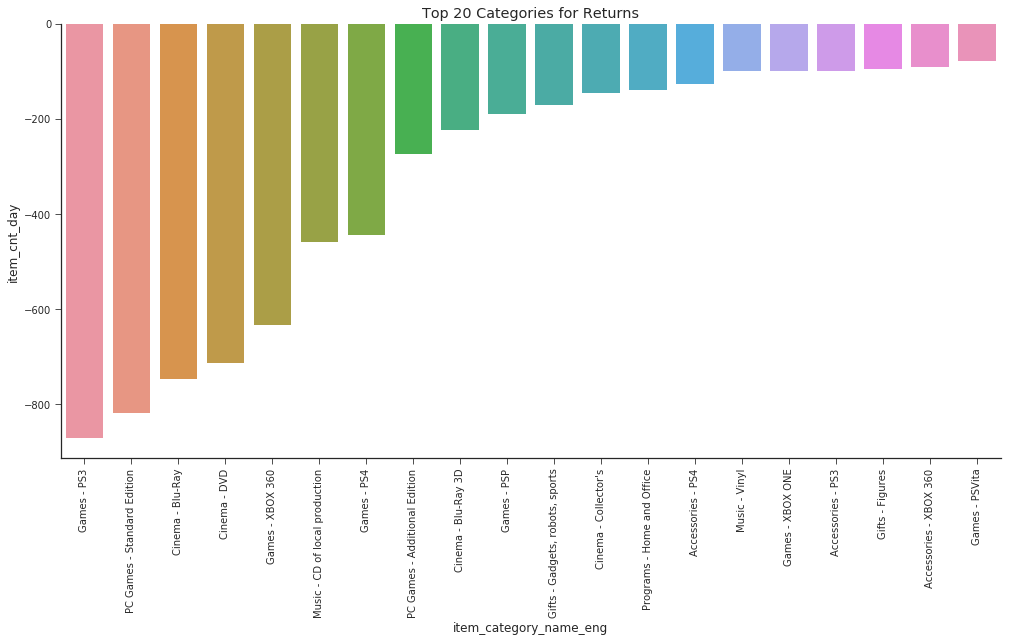

In [73]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)


sns.barplot(x='item_category_name_eng',y='item_cnt_day',
            data=joined[joined.item_cnt_day<0].groupby(['item_category_name_eng'])['item_category_name_eng','item_cnt_day'].sum().reset_index().sort_values('item_cnt_day').head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Categories for Returns')
sns.despine()

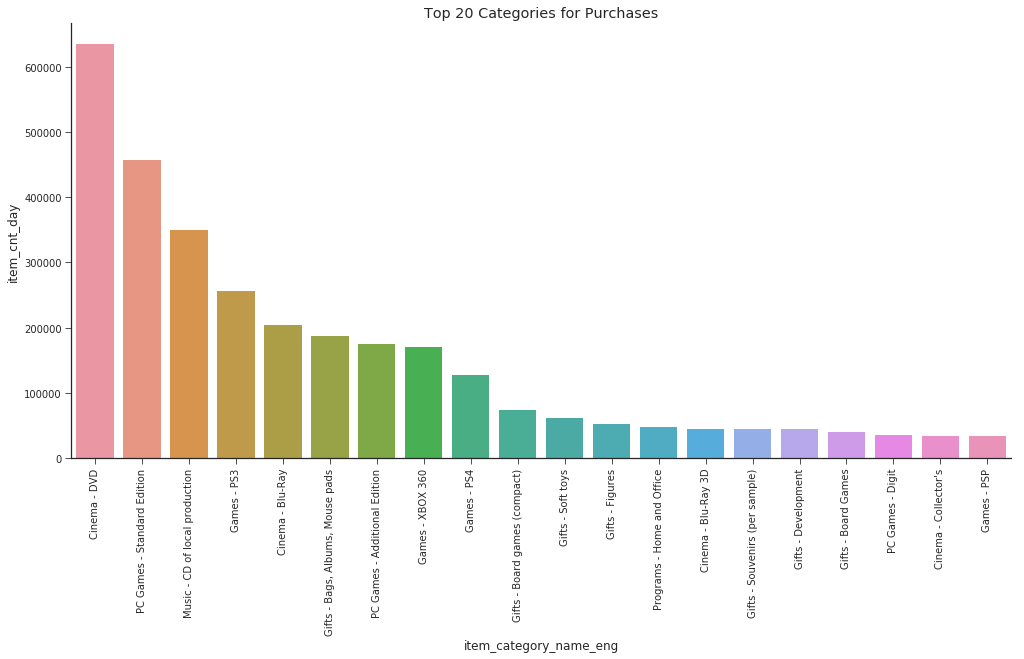

In [74]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)


sns.barplot(x='item_category_name_eng',y='item_cnt_day',
            data=joined[joined.item_cnt_day>0].groupby(['item_category_name_eng'])['item_category_name_eng','item_cnt_day'].sum().reset_index().sort_values('item_cnt_day',ascending=False).head(20))
plt.xticks(rotation=90)
plt.title('Top 20 Categories for Purchases')
sns.despine()